In [73]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

In [74]:
def sentiment_transform(label):
    def func(series):
        return series.isin(label).sum() / series.count()
    return func

In [75]:
def prepare_data(ticker):
    stock_price = pd.read_csv(f"../dataset/stocks/{ticker}.csv")
    stock_price['time'] = pd.to_datetime(stock_price['time'])
    stock_price['trade_date'] = stock_price['time'].dt.date
    stock_price['delta'] = stock_price['close'].diff()
    stock_price['prv_close'] = stock_price['close'].shift(periods=1, fill_value=None)
    
    stock_news = pd.read_csv(f"../dataset/polygon_title_sentiment/{ticker}_title_sentiments.csv")
    stock_news['time'] = pd.to_datetime(stock_news['time'])
    stock_news['trade_date'] = (stock_news['time'] + pd.to_timedelta(0, unit='h')).dt.date
    stock_news['neg_score'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'negative', 'neg_score'] = np.nan

    news_comb = pd.merge(stock_price, stock_news, how='left', on='trade_date')
    relation_gp = news_comb.groupby('trade_date').agg({
        'prv_close': 'first', 'delta': 'first', 'close': 'first', 'open': 'first', 'high': 'first', 'low': 'first',
        'sentiment': [sentiment_transform(['positive']), sentiment_transform(['negative'])], 'neg_score': 'mean'
    }).fillna(0.0).reset_index()
    relation_gp.columns = ['trade_date', 'prv_close', 'delta', 'close', 'open', 'high', 'low', 'positive', 'negative', 'neg_score']
    return relation_gp

In [76]:
relation_gp = prepare_data(ticker='AAPL')
relation_gp_t = relation_gp[relation_gp['negative'] > 0]
len(relation_gp_t), len(relation_gp)

/var/folders/pj/znl5r0ln0hv_g1yjdthtr3f40000gn/T/ipykernel_25479/2186838793.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return series.isin(label).sum() / series.count()


(438, 502)

In [77]:
def test_relevance(cols):
    X, y = relation_gp_t[cols], relation_gp_t['delta']
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    y_pred = model.predict(X)

    # Evaluate the model
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, r2, model.coef_

In [78]:
test_relevance(['negative'])

(6.942649011075657, 0.024855733697714877, array([-3.54940075]))

In [79]:
test_relevance(['negative', 'prv_close'])

(6.932500457710225, 0.02628116995551455, array([-3.60486329, -0.00377396]))

In [80]:
test_relevance(['neg_score', 'prv_close'])

(7.047464292706563, 0.010133684413618838, array([-2.44867333, -0.00374563]))

In [81]:
test_relevance(['negative', 'neg_score', 'prv_close'])

(6.894677519076728,
 0.03159366979301448,
 array([-3.34581544, -1.86528913, -0.00446983]))

In [82]:
test_relevance(['positive', 'negative', 'prv_close'])

(6.8115574211546654,
 0.04326847673973999,
 array([ 2.69990973, -2.6930782 , -0.00746153]))

In [83]:
test_relevance(['positive', 'negative', 'neg_score', 'prv_close'])

(6.767150295087289,
 0.049505772374084045,
 array([ 2.77537596, -2.38660293, -2.02328201, -0.00831941]))

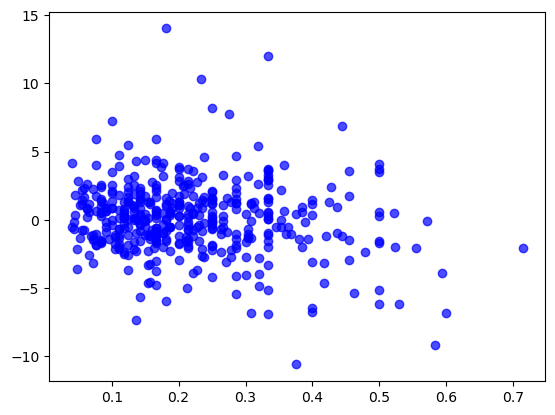

In [84]:
import matplotlib.pyplot as plt

plt.scatter(relation_gp_t['negative'], relation_gp_t['delta'], color='blue', alpha=0.7)

In [85]:
def preprocess(relation_gp):
    seq_length = 10
    std_scaler = StandardScaler()
    feat_cols = ['negative', 'close']
    df = pd.DataFrame()
    df[feat_cols] = std_scaler.fit_transform(relation_gp[feat_cols])

    X = []
    y = []
    for i in range(seq_length, len(df)):
        X.append(df.iloc[i-seq_length:i])
        y.append(df.iloc[i, -1])
    X = np.array(X)
    y = np.array(y)

    split_index = int(len(X) * 0.95)
    X, X_test = X[:split_index], X[split_index:]
    y, y_test = y[:split_index], y[split_index:]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=67)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) 
    y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1) 
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1) 

    return X_train, X_val, X_test, y_train, y_val, y_test

In [86]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, layers, dropout):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

In [87]:
model = SimpleLSTM(input_size=2, hidden_size=64, output_size=1, layers=2, dropout=0.5)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_train, X_val, X_test, y_train, y_val, y_test = preprocess(relation_gp)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

(torch.Size([396, 10, 2]),
 torch.Size([71, 10, 2]),
 torch.Size([25, 10, 2]),
 torch.Size([396, 1]),
 torch.Size([71, 1]),
 torch.Size([25, 1]))

In [88]:
class EarlyStopper:
    def __init__(self, min_steps=0, mem_ratio=1, threshold=0):
        self.min_steps = min_steps
        self.mem_ratio = mem_ratio
        self.threshold = threshold
        self.aveg_loss = 0
        self.steps = 0
        self.min_loss = float('inf')

    def early_stop(self, loss):
        self.steps += 1;
        self.aveg_loss = self.aveg_loss * self.mem_ratio + loss * (1-self.mem_ratio)
        if self.steps >= self.min_steps:
            self.min_loss = min(self.min_loss, self.aveg_loss)
            if self.aveg_loss >= self.min_loss * (1+self.threshold):
                return True
        return False

In [89]:
num_epochs = 1500
early_stopping = EarlyStopper(min_steps=200, mem_ratio=0.9, threshold=0.1)
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val).item()
    
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")
    
    # Early stopping check
    # if early_stopping.early_stop(val_loss):
    #     break

Epoch 1, Train Loss: 0.8476, Val Loss: 0.8214
Epoch 2, Train Loss: 0.8311, Val Loss: 0.8088
Epoch 3, Train Loss: 0.8149, Val Loss: 0.7957
Epoch 4, Train Loss: 0.8003, Val Loss: 0.7817
Epoch 5, Train Loss: 0.7830, Val Loss: 0.7664
Epoch 6, Train Loss: 0.7656, Val Loss: 0.7493
Epoch 7, Train Loss: 0.7476, Val Loss: 0.7302
Epoch 8, Train Loss: 0.7259, Val Loss: 0.7085
Epoch 9, Train Loss: 0.7026, Val Loss: 0.6836
Epoch 10, Train Loss: 0.6758, Val Loss: 0.6549
Epoch 11, Train Loss: 0.6439, Val Loss: 0.6218
Epoch 12, Train Loss: 0.6080, Val Loss: 0.5835
Epoch 13, Train Loss: 0.5693, Val Loss: 0.5395
Epoch 14, Train Loss: 0.5198, Val Loss: 0.4893
Epoch 15, Train Loss: 0.4670, Val Loss: 0.4327
Epoch 16, Train Loss: 0.4105, Val Loss: 0.3701
Epoch 17, Train Loss: 0.3430, Val Loss: 0.3032
Epoch 18, Train Loss: 0.2732, Val Loss: 0.2350
Epoch 19, Train Loss: 0.2112, Val Loss: 0.1704
Epoch 20, Train Loss: 0.1522, Val Loss: 0.1167
Epoch 21, Train Loss: 0.1046, Val Loss: 0.0812
Epoch 22, Train Loss: 

In [90]:
model.eval()

with torch.no_grad():
    outputs = model(X_test)
    loss = criterion(outputs, y_test)
    std = y_test.std()
    print(f'Test Loss: {loss.item():.4f}')
    print(f'Std: {std:.4f}')
    print(f'Error Range: {loss.sqrt() / std:.4f}')

Test Loss: 0.0134
Std: 0.1417
Error Range: 0.8158
